In [1]:
import numpy as np
from scipy.optimize import minimize
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
from scipy.linalg import eigh


In [2]:

#2a

def PCA(X, k):
    #calculate mean for X
    mu = np.mean(X, axis=0)
    X_adjust = X - mu

    #compute covariance matrix
    cv_matrix = X_adjust.T @ X_adjust

    eigenvalues, eigenvectors = eigh(cv_matrix)

    # Get indices for sorting eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]

    # Sort eigenvalues and eigenvectors using these indices
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    #kxd result matrix
    U = sorted_eigenvectors[:, :k].T

    return U

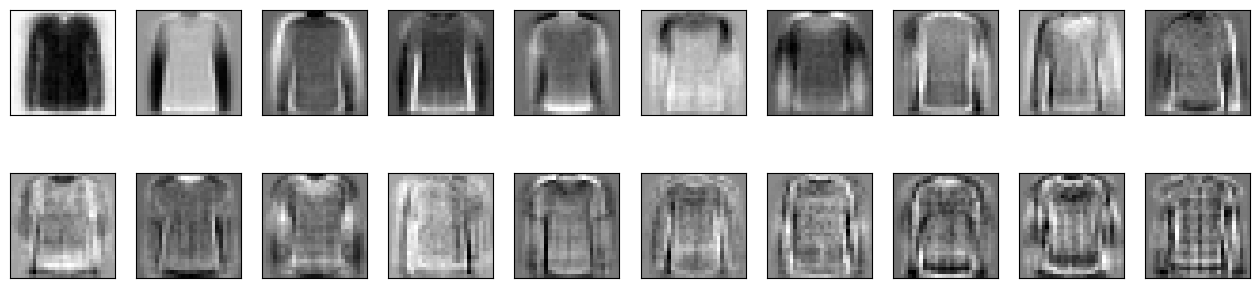

In [3]:
#2b

# Load the data

#data = np.loadtxt('/Users/dantefarinon-spezzano/Downloads/A3files/A3train.csv', delimiter=',')
data = np.loadtxt("/Users/mariopardo/OnThisMac/Programming/C3105_Group62/Assignment3/ProjectSpecs/A3files/A3train.csv", delimiter=',')
mean_vector = np.mean(data, axis=0)
data_centered = data - mean_vector

# Apply PCA with k=20
k = 20
U = PCA(data_centered, k)

#helper function given
def plotImgs(X):
    fig = plt.figure(figsize=(16, 6))
    for i in range(20):
        ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(X[i].reshape((28, 28)), cmap='gray')
    plt.show()
    return

plotImgs(U)

In [4]:
#2c

def projPCA(Xtest, mu, U):

    Xtest_centered = Xtest - mu.T
    x_proj = Xtest_centered @ U.T

    return x_proj

In [5]:

import numpy as np
from matplotlib import pyplot as plt
from scipy.special import logsumexp



def augmentX(X):
    n = X.shape[0]
    return np.concatenate((np.ones((n, 1)), X),  axis=1)


def unAugmentX(X):
    # Assume the first dimension has all ones
    return X[:, 1:]


def convertToOneHot(y, n_classes):
    # y should be a 1d array
    y = y.astype(int).flatten()
    Y = np.eye(n_classes)[y]
    return Y.astype(float)


def generateData(n, gen_model, rand_seed=None):

    d = 2
    shift = 1.8

    if rand_seed is not None:
        np.random.seed(rand_seed)

    X = []
    y = []
    m = n // 4
    class_label = 0
    for i in [-1, 1]:
        for j in [-1, 1]:
            if gen_model == 1:
                X.append(np.random.randn(m, d) + 
                         class_label * shift)
            elif gen_model == 2:
                X.append(np.random.randn(m, d) + 
                         shift * np.array([[i, j]]))
            else:
                raise ValueError("Unknown generative model")
            y.append(np.ones((m, 1)) * class_label)
            class_label += 1
    X = np.vstack(X)
    y = np.vstack(y)

    return X, convertToOneHot(y, 4)


def plotPoints(X, Y):
    # plot the data points
    k = Y.shape[1]
    markers = ['o', '+', 'd', 'x', '^', 'v', 's']
    colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k']
    labels = Y.argmax(axis=1)
    for i in range(k):
        Xpart = X[labels == i]

        plt.scatter(Xpart[:, 0], Xpart[:, 1], 
                    marker=markers[i], 
                    color=colors[i],
                    label=f'class {i}')
    return


def getRange(X):
    x_min = np.amin(X[:, 0]) - 0.1
    x_max = np.amax(X[:, 0]) + 0.1
    y_min = np.amin(X[:, 1]) - 0.1
    y_max = np.amax(X[:, 1]) + 0.1
    return x_min, x_max, y_min, y_max


def plotModel(X, Y, W, classify):

    X = unAugmentX(X)
    plotPoints(X, Y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    Y = classify(np.c_[np.ones(len(xx.ravel())), xx.ravel(), yy.ravel()], W)
    labels = Y.argmax(axis=1)

    # Put the result into a color plot
    labels = labels.reshape(xx.shape)
    plt.contourf(xx, yy, labels, 
                 colors=['r', 'r', 'b', 'b', 'g', 'g', 'y', 'y'], 
                 alpha=0.3)
    plt.legend()
    plt.show()
    return



def plotImg(x):
    img = x.reshape((28, 28))
    plt.imshow(img, cmap='gray')
    plt.show()
    return


def plotImgs(X):
    # plot the first 20 images of X
    fig = plt.figure(figsize=(16, 6))
    for i in range(20):
        ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(X[i].reshape((28, 28)), cmap='gray')
    plt.show()
    return





#Q1b

def classify(X,W):
    WX = np.dot(X,W)
    indmax = np.argmax(WX, axis=1)

    return convertToOneHot(indmax, WX.shape[1])
#Q1c

def calculateAcc(Yhat, Y):
    return np.mean(np.all(Yhat == Y,axis=1))


#Q1a

def multinomial_deviance_loss(W, X, Y, d, k):

    W = W.reshape(d, k)
    WX = np.dot(X, W)

    log_sum_exp = logsumexp(WX, axis=1)
    y_WX = np.sum(WX * Y, axis=1)
    
    loss = np.mean(log_sum_exp - y_WX)
    
    return loss

def minMulDev(X, Y):
    n, d = X.shape
    k = Y.shape[1]
    
    #must be 1D Array as this is what minimize requires
    W_init = np.zeros(d * k)
    
    def objective(W):
        return multinomial_deviance_loss(W, X, Y, d, k)

    result = minimize(objective, W_init, method='L-BFGS-B')
    
    return result.x.reshape(d, k)
    


    

In [6]:
#2d

import numpy as np

def synClsExperimentsPCA():
    n_runs = 100
    n_train = 128
    n_test = 1000
    dim_list = [1, 2]
    gen_model_list = [1, 2]

    train_acc = np.zeros((len(dim_list), len(gen_model_list), n_runs))
    test_acc = np.zeros((len(dim_list), len(gen_model_list), n_runs))

    for r in range(n_runs):
        for i, k in enumerate(dim_list):
            for j, gen_model in enumerate(gen_model_list):
                # Generate training and test data
                Xtrain, Ytrain = generateData(n=n_train, gen_model=gen_model)  
                Xtest, Ytest = generateData(n=n_test, gen_model=gen_model)      

                # Perform PCA on the training data
                U = PCA(Xtrain, k) 

                # Project the training and test data
                mu = np.mean(Xtrain, axis=0)  # Calculate mean vector for training data 
                Xtrain_proj = projPCA(Xtrain, mu, U)  # Call projPCA to get the new features 
                Xtest_proj = projPCA(Xtest, mu, U)    # Call projPCA to get the new features 

                # Data augmentation (if applicable)
                Xtrain_proj = augmentX(Xtrain_proj)   
                Xtest_proj = augmentX(Xtest_proj)     

                # Train the model on projected and augmented training data
                W = minMulDev(Xtrain_proj, Ytrain)   

                # Calculate training accuracy
                Yhat_train = classify(Xtrain_proj, W) 
                train_acc[i, j, r] = calculateAcc(Yhat_train, Ytrain)  

                # Calculate test accuracy
                Yhat_test = classify(Xtest_proj, W)  
                test_acc[i, j, r] = calculateAcc(Yhat_test, Ytest)  

    # TODO: Compute the average accuracies over the runs
    avg_train_acc = np.mean(train_acc, axis=2)  
    avg_test_acc = np.mean(test_acc, axis=2)   

    return avg_train_acc, avg_test_acc  


# Run the function
avg_train_acc, avg_test_acc = synClsExperimentsPCA()

# Display the results
print("Average Training Accuracy:\n", avg_train_acc)
print("Average Test Accuracy:\n", avg_test_acc)


Average Training Accuracy:
 [[0.85710937 0.63015625]
 [0.85648437 0.93976563]]
Average Test Accuracy:
 [[0.84525 0.62261]
 [0.83815 0.9161 ]]
